# Results from Thailand LoRa experiments, 5.-6. Feb 2020
Authors:

- Anna Förster, May-June 2020
- Jens Dede, Dec 2023

<p>The objective of this experiment was to test the transmission radius of LoRa communication in a hilly environment in Thailand close to the RTIC Rajanagarindra Tropical Disease International Centre in Suan Phueng district.</p>
<p>The experiment consisted of two devices: the receiver was installed in the hotel close by, with wall power. The transmitter was carried down the street to the RTIC center. LoPy devices were used with generic code available under <a href="https://github.com/ComNets-Bremen/LoPy-Distance" target="_blank" rel="noopener">https://github.com/ComNets-Bremen/LoPy-Distance</a></p>
<p>The transmitter was transmitting a single packet upon pressing of a button. No special attention was given to line of sight. Here some pictures from the experiment:</p>
<p>&nbsp;</p>
<p style="text-align: center;"><strong>The RTIC Center</strong></p>
<p><img style="display: block; margin-left: auto; margin-right: auto;" src="images/RTIC.jpg" width="500" height="500" /></p>
<p>&nbsp;</p>
<p style="text-align: center;"><strong>The receiver at the hotel</strong></p>
<p><img style="display: block; margin-left: auto; margin-right: auto;" src="images/receiver.jpg" width="500" height="500" /></p>
<p>&nbsp;</p>
<p style="text-align: center;"><strong> The environment is hilly</strong></p>
<p><img style="display: block; margin-left: auto; margin-right: auto;" src="images/hills.jpg" width="500" height="500" /></p>

In [1]:
%matplotlib inline
# read all results files
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import ticker

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


figsize = (6,3)


# the moving transmitter
raw_data_TX = np.genfromtxt("node2_TX.csv", skip_header=1, delimiter = ';')
# the static receiver or base station
raw_data_RX = np.genfromtxt("node1_RX.csv", skip_header=1, delimiter = ';')

tx_latitude = raw_data_TX[:,0] # first column
tx_longitude = raw_data_TX[:,1]
tx_tx_time = raw_data_TX[:,2]

rx_latitude = raw_data_RX[:,0] # first column
rx_longitude = raw_data_RX[:,1]
rx_rx_time = raw_data_RX[:,2]
rx_tx_time = raw_data_RX[:,4]
rx_rssi = raw_data_RX[:,6]
rx_snr = raw_data_RX[:,7]
print('Total number of transmitted packets: ' + str(tx_latitude.size))
print('Total number of received packets: ' + str(rx_latitude.size))

BBox = [99.26, 99.28, 13.38, 13.40]

# the mean coordinates of the base station were:
rx_long = rx_longitude[~np.isnan(rx_longitude)].mean()
rx_lat = rx_latitude[~np.isnan(rx_latitude)].mean()


Total number of transmitted packets: 315
Total number of received packets: 90


The quality of reception can be analysed in terms of RSSI (Receved Signal Strength Ratio) and SNR (Signal-to-Noise-Ratio) and in correlation with distance.

Compute the distance between any transmission point and the mean coordinates of the receiver

In [2]:
# compute distance between receiver and the moving transmitter
from geopy.distance import geodesic

distances_geo = []

for i in range(0, tx_latitude.size):
    if np.isnan(tx_latitude[i]) or np.isnan(tx_longitude[i]):
        distances_geo.append(-1)
    else:
        distances_geo.append(geodesic((tx_latitude[i], tx_longitude[i]), (rx_lat, rx_long)).m)
    
    

In [3]:
# Now we need to filter only the received packets 
received_packets_distances = []
for i in range(rx_tx_time.size):
    wh = np.where(tx_tx_time == rx_tx_time[i])
    received_packets_distances.append(distances_geo[wh[0][0]])


Text(0, 0.5, 'RSSI in dBm')

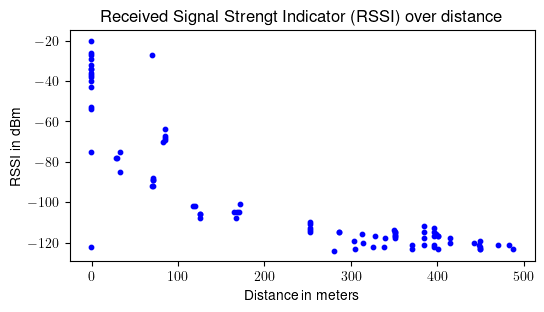

In [4]:
# Plot the RRSI over distance
fig, ax = plt.subplots(figsize = figsize)
ax.scatter(received_packets_distances, rx_rssi, zorder=1, alpha= 1, c='b', s=10)
#ax.scatter(rx_long, rx_lat, zorder=1, alpha= 1, c='k', s=50)
#ax.scatter(tx_longitude, tx_latitude, zorder=1, alpha= 0.2, c='r', s=10)
ax.set_title('Received Signal Strengt Indicator (RSSI) over distance')
ax.set_xlabel('Distance in meters')
ax.set_ylabel('RSSI in dBm')

Text(0, 0.5, 'SNR')

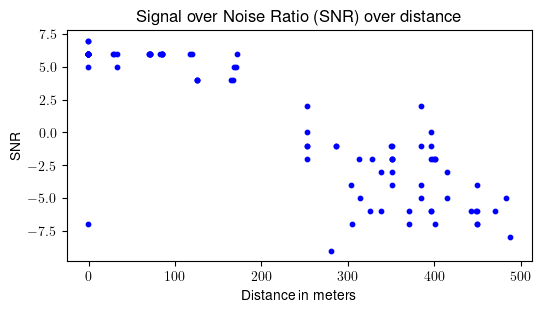

In [5]:
# Plot the SNR over distance
fig, ax = plt.subplots(figsize = figsize)
ax.scatter(received_packets_distances, rx_snr, zorder=1, alpha= 1, c='b', s=10)
#ax.scatter(rx_long, rx_lat, zorder=1, alpha= 1, c='k', s=50)
#ax.scatter(tx_longitude, tx_latitude, zorder=1, alpha= 0.2, c='r', s=10)
ax.set_title('Signal over Noise Ratio (SNR) over distance')
ax.set_xlabel('Distance in meters')
ax.set_ylabel('SNR')

In [6]:
# compute now the reception over distance
received_packets_success = []
for i in range(tx_tx_time.size):
    received_packets_success.append(tx_tx_time[i] in rx_tx_time)
    
PRR = received_packets_success.count(True)/tx_tx_time.size
print('Reception ratio: '+ str(round(PRR,2)))



Reception ratio: 0.29


Text(0, 0.5, 'Reception of packets (0 == lost, 1 == received)')

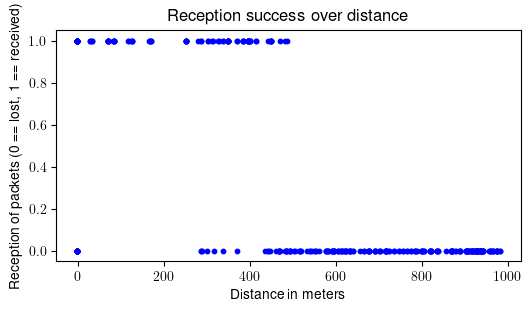

In [7]:
# Plot the reception over distance
fig, ax = plt.subplots(figsize = figsize)
ax.scatter(distances_geo, received_packets_success, zorder=1, alpha= 1, c='b', s=10)
ax.set_title('Reception success over distance')
ax.set_xlabel('Distance in meters')
ax.set_ylabel('Reception of packets (0 == lost, 1 == received)')

74


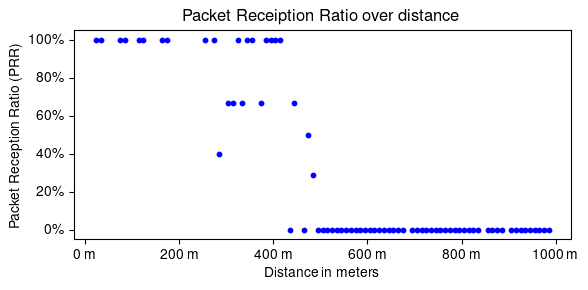

In [8]:
"""
Calculate the PRR over distance
"""

from operator import itemgetter, attrgetter

range_step = 10
range_end  = 1000

r = np.arange(0, range_end + range_step, range_step)

geo_pairs = zip(distances_geo, received_packets_success)
geo_pairs = [gp for gp in geo_pairs if gp[0] > 0]
geo_pairs = sorted(geo_pairs, key=itemgetter(0))

summed_dict = dict()

for i in range(len(r)):
    if i == 0:
        continue
    dist_code = r[i-1]+((r[i]-r[i-1])/2)
    
    summed_dict[dist_code] = []
    for gp in geo_pairs:
        if r[i-1] < gp[0] <= r[i]:
            summed_dict[dist_code].append(gp[1])
dist_values = []

for k in summed_dict:
    if len(summed_dict[k]) == 0:
        continue
        
    prr = summed_dict[k].count(True) / len(summed_dict[k])
    dist_values.append((k, prr))
    
dist_values = sorted(dist_values, key=itemgetter(0))
dist, prr = zip(*dist_values)

print(len(prr))


# Plot the RRSI over distance
fig, ax = plt.subplots(figsize = figsize)
ax.scatter(dist, prr, zorder=1, alpha= 1, c='b', s=10)
ax.set_title('Packet Receiption Ratio over distance')
ax.set_xlabel('Distance in meters')
ax.set_ylabel('Packet Reception Ratio (PRR)')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
ax.xaxis.set_major_formatter('{x:.0f} m')

fig.tight_layout()
fig.savefig("lora_prr.pdf")


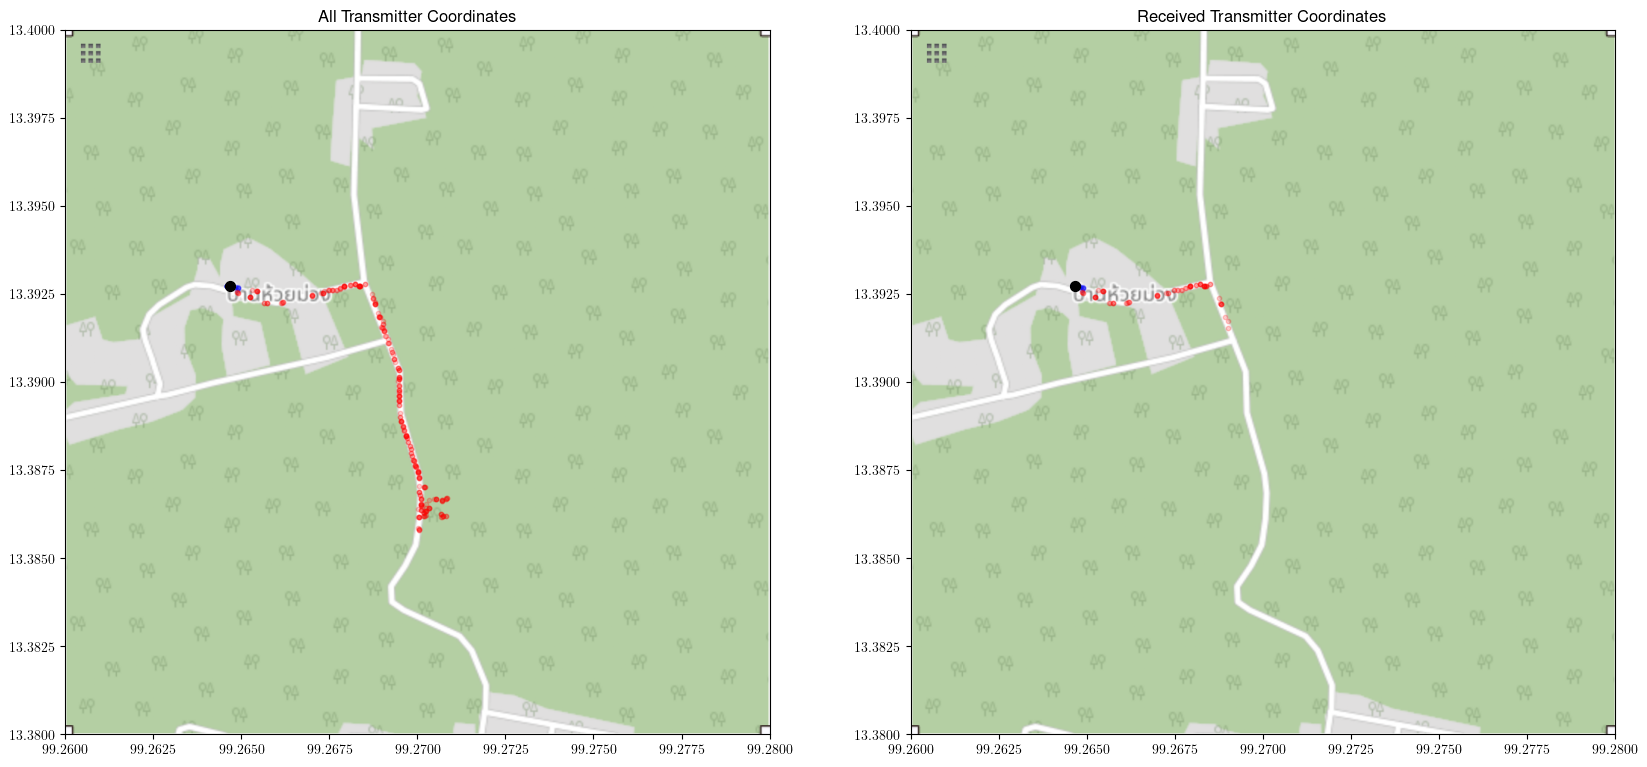

In [9]:
# Plot the transmitted and teh recievd packets on a map
ruh_m = plt.imread('images/map2.png')
#fig, ax = plt.subplots(figsize = (10,10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,20))
#ax1.figsize(10,10)
ax1.scatter(rx_longitude, rx_latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax1.scatter(rx_long, rx_lat, zorder=1, alpha= 1, c='k', s=50)
ax1.scatter(tx_longitude, tx_latitude, zorder=1, alpha= 0.2, c='r', s=10)
ax1.set_title('All Transmitter Coordinates ')
ax1.set_xlim(BBox[0],BBox[1])
ax1.set_ylim(BBox[2],BBox[3])
ax1.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

received_packets_lat = []
received_packets_long = []
for i in range(tx_tx_time.size):
    if tx_tx_time[i] in rx_tx_time:
        received_packets_long.append(tx_longitude[i])
        received_packets_lat.append(tx_latitude[i])
        

ax2.scatter(rx_longitude, rx_latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax2.scatter(rx_long, rx_lat, zorder=1, alpha= 1, c='k', s=50)
ax2.scatter(received_packets_long, received_packets_lat, zorder=1, alpha= 0.2, c='r', s=10)
ax2.set_title('Received Transmitter Coordinates')
ax2.set_xlim(BBox[0],BBox[1])
ax2.set_ylim(BBox[2],BBox[3])
ax2.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

<h3>Conclusion</h3>
<p>It can be concluded that LoRa is suited for communication, but needs a network of repetears or a network of base station to cover large areas. The communication works well up to a distance of approx. 300-400 meters and stop wokring at all at a distance of approx. 500 meters.</p>